<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Physique des ondes
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Paquet d'onde | Paquet d'onde & milieu non dispersif et non absorbant
             </div>
        </div>
    </div>
</div>

<b>*ATTENTION!*
Les calculs engagés dans ce notebook sont longs et ne peuvent être raccourcis qu'au prix d'une erreur numérique parfois conséquente. Une exécution pas à pas est recommandée.</b>

&nbsp;
<b>De même, les valeurs par défaut des diverses grandeurs `Num_x`, `L`, `lambda0` etc.. sont le fruit de nombreux tests. Vous vous éloignerez de ces valeurs *à vos risques et périls (numériques)*... </b>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
##  Propagation d'une onde électromagnétique

On étudie la propogation d'une onde électromagnétique dans le divers milieux en commençant par le plus simple : le vide.

&nbsp;
Le domaine étudié à une longueur de $L=50~\text{m}$, la longueur d'onde choisie est $\lambda_0=1~\text{m}$, et, pour rendre plus lisibles les résultats, on fixera la célérité des ondes dans le vide à $c=1~\text{m.s}^{-1}$. On en déduit la valeur de la pulsation associée dans le vide, noté $\omega_0$.

In [2]:
# Domaine de calcul
L = 50 # longueur

# Signal EMAG
E_amp = 1 # amplitude
lambda0 = 1 # longueur d'onde
sigma0 = 1 / lambda0 # nombre d'onde
c = 1 # célérité 
omega0=2*np.pi*sigma0*c # pulsation associée à la longueur d'onde

## Variables numériques
Les variables numériques spatiales, nombre de points et pas d'espace sont `Num_x` et `delta_x`, tandis que les variables temporelles sont `Num_t` et `delta_t`.

In [3]:
# Intégration spatiale
Num_x = 5001 # points de calcul
x=np.linspace(0,L,Num_x) # vecteur position
delta_x = x[1]-x[0] # intervalle spatial d'intégration


# Intégration temporelle
Num_t = 10001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

# Propagation d'une onde dans le vide (milieu non dispersif et non absorbant)

## Forme d'onde simple, fenêtre de Hann
Pour créer une forme d'onde simple mais non purement sinusoïdale, qui pourra ensuite servir à créer un paquet d'onde, on définit une fonction `Hann` qui calcule une fenêtre de Hann de largeur $H$, centrée sur un point $x_0$. Cette forme sera utilisée pour la première onde étudiée.

In [4]:
x0=L/2 # position initiale de la forme d'onde

## Fenêtre de définition de la forme d'onde
def Hann(x,x0,H):
    func=np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i]-x0)<H/2:
            func[i]=.5*(1-np.cos(2*np.pi*(x[i]-x0+H/2)/H))
    return func

## Forme d'onde à l'instant t, t-dt et t+dt
E0  = E_amp*Hann(x,x0,lambda0)
E0_old  = E_amp*Hann(x,x0-c*delta_t,lambda0)
E0_new  = E_amp*Hann(x,x0+c*delta_t,lambda0)

On trace la première forme d'onde :

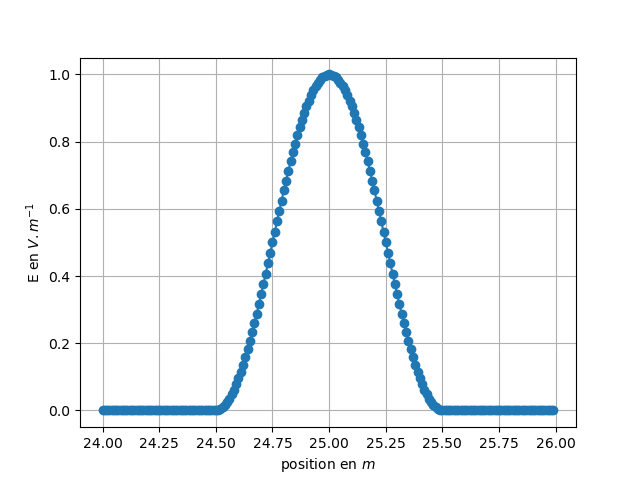

In [5]:
# Tracé de la forme d'onde avec zoom sur la partie centrale du domaine de calcul
plt.figure()
Nx=int(lambda0//delta_x)
plt.plot(x[int(2.4*Num_x//5):int(2.6*Num_x//5)],E0[int(2.4*Num_x//5):int(2.6*Num_x//5)],'-o')
plt.xlabel(r"position en $m$")
plt.ylabel(r"E en $V.m^{-1}$")
plt.grid(True)
plt.show()

Ainsi que son spectre :

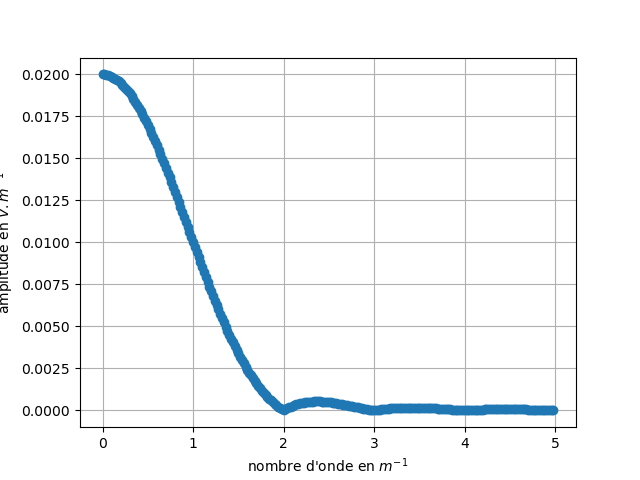

In [6]:
# Spectre spatial du signal
y = np.fft.rfft(E0/(len(E0)//2+1))
freq = np.array([i/np.max(x) for i in range(len(y))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq[:int(Num_x//20)],np.abs(y)[:int(Num_x//20)],'-o')
plt.xlabel(r"nombre d'onde en $m^{-1}$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.grid(True)
plt.show()

### Propagation spontanée
La forme d'onde est placée au centre du domaine, sans vitesse initiale. On laisse alors l'équation de d'Alembert numérisée décider de sa propagation.

&nbsp;
L'onde électromagnétique obéit à l'équation de d'Alembert 1D cartésienne : 
$$\dfrac{\partial^2 E}{\partial t^2}=c^2\dfrac{\partial^2E}{\partial x^2}$$

### Approche numérique

La résolution numérique d'une dérivée temporelle d'ordre 2 demande de connaître la forme d'onde aux instants $t-\text{d}t$ (notée `E_old`), $t$ (notée `E`) et $t+\text{d}t$ (`E_new`), ainsi que le laplacien du champ à l'instant $t$, noté `d2Ex`.

&nbsp;
Le laplacien peut-être calculé sur 3 ($i-1$, $i$ et $i+1$) ou 5 points ($i-2$ à $i+2$), ce dernier étant plus précis :
* 3 points : $\frac{E_{i+1}+E_{i-1}-2E_i}{\Delta x^2}$
* 5 points : $\frac{-E_{i+2}+16E_{i+1}-30E_i+16E_{i-1}-E_{i-2}}{12\Delta x^2}$

Les bords du domaine posent donc problèmes et seront traités à part. On utilisera des conditions aux limites dites "de réflexion totale", plus simples à implémenter, en fixant la valeur de $E(x=0)=E(x=L)=0$.

&nbsp;

Il ne reste alors qu'à mettre en œuvre la résolution itérative à chaque instant $t_k$ qui s'écrit :
`E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex`

&nbsp;
On peut alors calculer l'évolution de l'onde sur un intervalle de temps de $20~\text{s}$ qui doit permettre à l'onde d'approcher des bordures sans les atteindre.

### Forme d'onde simple

In [7]:
# On suppose la forme d'onde présente pour tout t<0 et immobile
E=E0
E_old=E0
E_new=E0
d2Ex=np.zeros(Num_x) # initialisation du laplacien de E qui sera calculé plus loin

E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants

duree = 20

k, time = 0,0
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

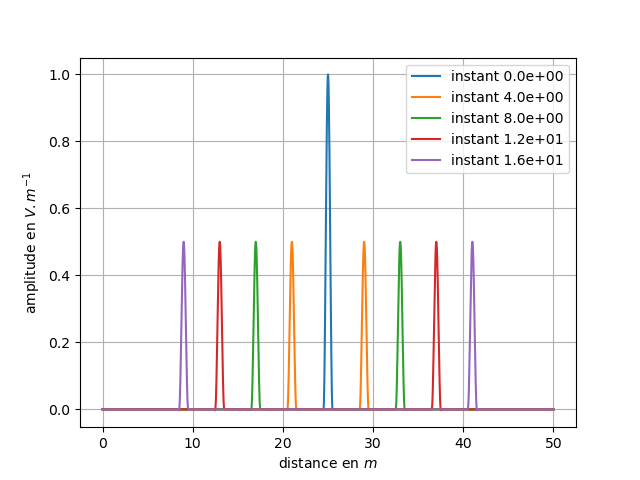

In [8]:
plt.figure()
plt.grid(True)
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

La forme d'onde ne scinde donc en deux, l'une se propageant dans le sens des $x$ croissants et l'autre dans l'autre sens. Les deux se propagent à la même vitesse que l'on peut calculer et comparer à celle attendue.

&nbsp;
On relève la coordonnée du maximum de l'onde rétrograde finale, on lui retranche celle de l'onde initiale et on divise par la durée de la simulation. Cette valeur est alors comparée à $c$.

In [9]:
# On ne prend pas en compte l'instant initial (distance nulle et division par 0)
pos = np.array([np.abs(x[np.argmax(abs(E0))]-x[np.argmax(abs(E_store[i]))]) for i in range(1,len(E_store))])
v_phi = np.array([pos[i]/((i+1)*duree/5) for i in range(len(pos))])

v_phi_moy=np.mean(v_phi)
v_phi_u=np.std(v_phi, ddof=1)
print("La vitesse de propagation moyenne de l'onde simulée est de ",format(v_phi_moy,"#.3e"),"m/s")
print("L'écart-type de la vitesse de propagation de l'onde simulée est de ",format(v_phi_u,"#.3e"),"m/s")

La vitesse de propagation moyenne de l'onde simulée est de  1.001e+00 m/s
L'écart-type de la vitesse de propagation de l'onde simulée est de  8.398e-04 m/s


Le résultat obtenu est très bon.

### Animation
L'animation ci-dessous a été réalisée avec le paramètre `H=4*lambda0` de façon à bien voir la séparation de la forme d'onde initiale en deux ondes progressives de la forme $f(x-ct)$ et $g(x+ct)$.

In [10]:
from IPython.display import Video

Video("prop_vide.mp4", width=640)

### Forme d'onde plus complexe : le paquet d'onde
On peut donc utiliser ce script pour étudier la propagation d'une onde plus complexe sur une plus grande distance.

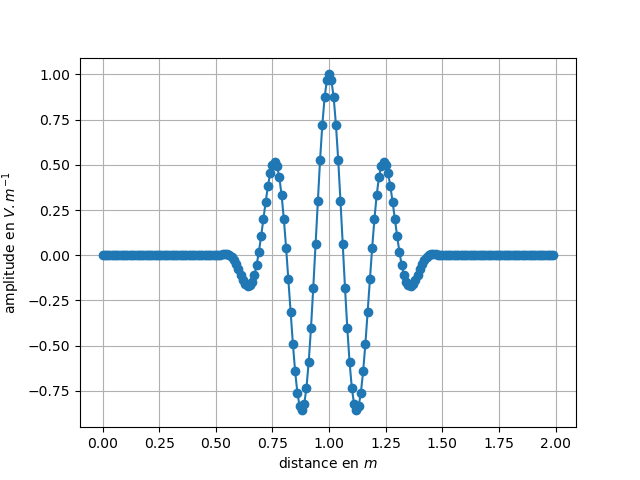

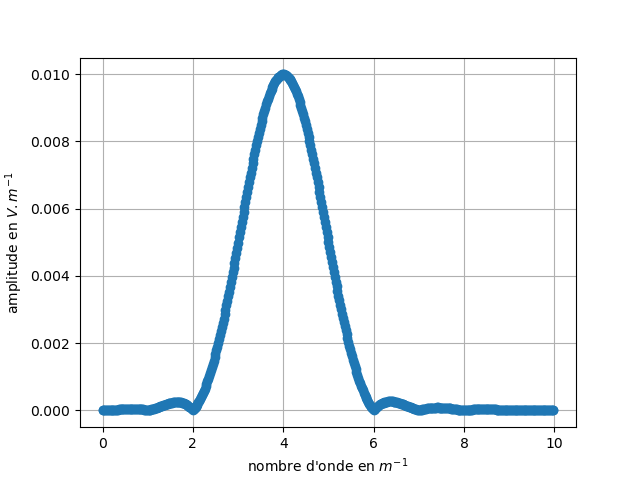

In [11]:
## Forme d'onde à l'instant t, t-dt et t+dt
x0=L/50

E0 = E_amp*Hann(x,x0,lambda0)*np.cos(2*np.pi*x*4/lambda0)
E0_old  = E_amp*Hann(x,x0-c*delta_t,lambda0)*np.cos(2*np.pi*(x+c*delta_t)*4/lambda0)
E0_new  = E_amp*Hann(x,x0+c*delta_t,lambda0)*np.cos(2*np.pi*(x-c*delta_t)*4/lambda0)

# Tracé de la forme d'onde
plt.figure()
Nx=int(lambda0//delta_x)
plt.plot(x[:Num_x//25],E0[:Num_x//25],'-o')
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.grid(True)
plt.show()

# Spectre spatial du signal
y = np.fft.rfft(E0/(len(E0)//2+1))
freq = np.array([i/np.max(x) for i in range(len(y))])

plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq[:int(Num_x//10)],np.abs(y)[:int(Num_x//10)],'-o')
plt.xlabel(r"nombre d'onde en $m^{-1}$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.grid(True)
plt.show()

In [12]:
##################################
### PAQUET D'ONDE DANS LE VIDE ###
##################################

# Intégration temporelle, replacée ici pour pouvoir modifier à loisir Num_t sans conséquences pour la suite
Num_t = 10001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt
x0=L/50

E = E_amp*Hann(x,x0,lambda0)*np.cos(2*np.pi*x*4/lambda0)
E_old  = E_amp*Hann(x,x0-c*delta_t,lambda0)*np.cos(2*np.pi*(x+c*delta_t)*4/lambda0)
E_new  = E_amp*Hann(x,x0+c*delta_t,lambda0)*np.cos(2*np.pi*(x-c*delta_t)*4/lambda0)

E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants

d2Ex=np.zeros(Num_x)

duree = 45
k, time = 0,0.
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex
    E_old, E = E, E_new
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

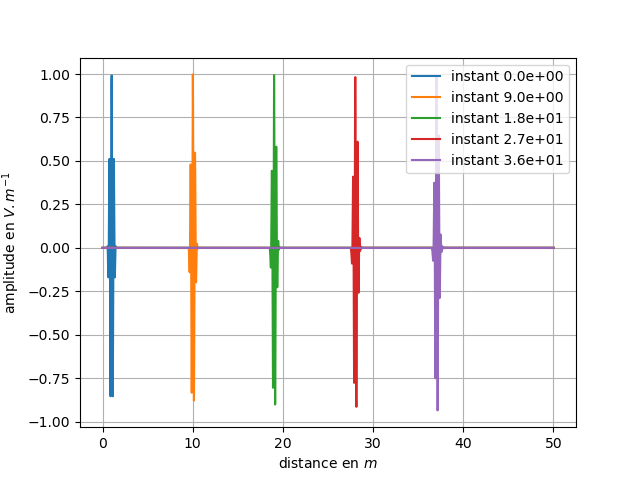

La vitesse de propagation moyenne de l'onde simulée est de  1.001e+00 m/s
L'écart-type de la vitesse de propagation de l'onde simulée est de  1.909e-04 m/s


In [13]:
plt.figure()
plt.grid(True)
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

# On ne prend pas en compte l'instant initial (distance nulle et division par 0)
pos = np.array([np.abs(x[np.argmax(abs(E0))]-x[np.argmax(abs(E_store[i]))]) for i in range(1,len(E_store))])
v_phi = np.array([pos[i]/((i+1)*duree/5) for i in range(len(pos))])

v_phi_moy=np.mean(v_phi)
v_phi_u=np.std(v_phi, ddof=1)
print("La vitesse de propagation moyenne de l'onde simulée est de ",format(v_phi_moy,"#.3e"),"m/s")
print("L'écart-type de la vitesse de propagation de l'onde simulée est de ",format(v_phi_u,"#.3e"),"m/s")

La vitesse de propagation est à nouveau correctement évaluée mais un écart apparaît pour des pas de temps trop importants qui se confirme si on regarde de près la forme d'onde après propagation. 

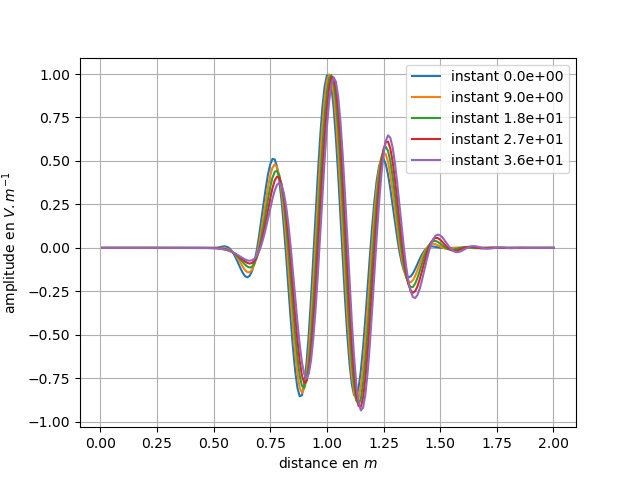

In [14]:
start=[int(x[np.argmax(abs(E0))] + i*c*duree/(5*delta_x)) for i in range(len(E_store))]
end = [start[i]+int(2*lambda0/delta_x) for i in range(len(E_store))]

end0=int(2*lambda0/delta_x)

plt.figure()
for i in range(len(start)):
    plt.plot(x[start[0]:end[0]],E_store[i][start[i]:end[i]], label="instant "+str(format(time_store[i], "#.1e")))
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.grid(True)
plt.show()


Le résultat s'améliore nettement si on augmente `Num_x`. Une valeur de 20001 est un bon compromis que l'on conservera par la suite.

### Animation

On peut le constater sur l'animation suivante, réalisée pour $H=10\lambda_0$ et $\lambda=\lambda_0$.

In [15]:
from IPython.display import Video

Video("prop_vide_paquet.mp4", width=640)

## Relation de dispersion
La relation de dispersion, associée à l'équation de d'Alembert, s'écrit : 
$$c^2k^2=\omega^2\Longleftrightarrow c=\lambda_0 f$$

La longueur d'onde se déduit du spectre spatial de la forme d'onde à un instant donné. On peut donc la calculer sur le signal initial `E0`. La fréquence se déduit du spectre temporel, que l'on doit établir en plaçant un capteur sur la trajectoire de l'onde et en stockant la valeur du signal en ce point à chaque instant dans le vecteur `capteur`.

&nbsp;
Il ne reste qu'à calculer le spectre du vecteur `capteur`, et à le comparer à celui de $c/\lambda_0=c\sigma_0$.

In [16]:
##################################
### PAQUET D'ONDE DANS LE VIDE ###
##################################

# Intégration temporelle, replacée ici pour pouvoir modifier à loisir Num_t sans conséquences pour la suite
Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt
x0=L/50

E = E_amp*Hann(x,x0,lambda0)*np.cos(2*np.pi*x*4/lambda0)
E_old  = E_amp*Hann(x,x0-c*delta_t,lambda0)*np.cos(2*np.pi*(x+c*delta_t)*4/lambda0)
E_new  = E_amp*Hann(x,x0+c*delta_t,lambda0)*np.cos(2*np.pi*(x-c*delta_t)*4/lambda0)

capteur=[] # on place un capteur en x=L/2, soit k=Num_x//2, on réduit la durée de la simulation

d2Ex=np.zeros(Num_x)

duree = 25
k, time = 0,0.
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((c*delta_t)**2)*d2Ex
    E_old, E = E, E_new
    capteur.append(E[Num_x//2])
    k += 1
    time += delta_t

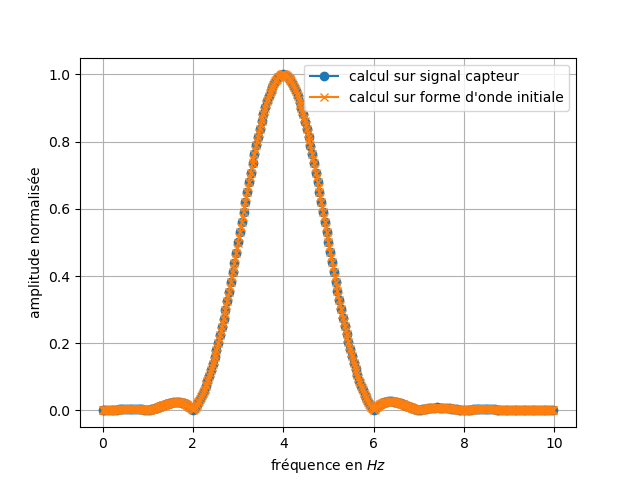

In [17]:
### Spectre du signal mesuré
## Spectre spatial
y = np.fft.rfft(E0/(len(E0)//2+1))
sigma = np.array([i/np.max(x) for i in range(len(y))])

## Spectre temporel
y2 = np.fft.rfft(np.array(capteur)/(len(capteur)//2+1))
freq = np.array([i/duree for i in range(len(y))])

plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq[:int(Num_x//20)],np.abs(y2)[:int(Num_x//20)]/np.max(np.abs(y2)),'-o', label="calcul sur signal capteur")
plt.plot(sigma[:int(Num_x//10)]*c,np.abs(y)[:int(Num_x//10)]/np.max(np.abs(y)),'-x', label="calcul sur forme d'onde initiale")
plt.legend()
plt.xlabel(r"fréquence en $Hz$")
plt.ylabel('amplitude normalisée')
plt.grid(True)
plt.show()

## Réflexion d'onde sur un dioptre en incidence normale - Formule de Fresnel
Lors de la réflexion d'une onde sur un dioptre en incidence normale, l'onde incidente donne naissance à une onde transmise et une onde réfléchie. L'amplitude associée à ces ondes dépend bien sûr de celle de l'onde incidente mais également des indices optiques des milieux de part et d'autre du dioptre. 

&nbsp;
Les relations de Fresnel nous donne l'expression de ces coefficients :
$$r=\dfrac{n_i-n_t}{n_i+n_t}\qquad t=\dfrac{2n_i}{n_i+n_t}$$
où $n_i$ (resp. $n_t$) est l'indice optique du milieu où se propage l'onde incidente (resp. transmise). On rappelle que l'indice optique vérifie : 
$$n=\dfrac{c}{v}$$
où $c$ est la célérité de la lumière dans le vide (ici prise à $1~\text{m.s}^{-1}$ et $v$ celle de la lumière dans le milieu considéré. Ces relations peuvent donc également s'écrire sous la forme :
$$r=\dfrac{c_t-c_i}{c_t+c_i}\qquad t=\dfrac{2 c_t}{c_t+c_i}$$

&nbsp;
On va donc scinder en deux le domaine de calcul et créer une fonction `celerite(c1,c2,L)` qui renvoie un vecteur `cel` contenant deux valeurs possibles de la célérité : $c=c_i$ si $x<L$ et $c=c_t$ si $x>L$. Ce vecteur est alors utilisé dans la relation de récurrence de la propagation d'onde dans un milieu non dispersif.

&nbsp;
Il suffit alors de mesurer l'amplitude de $E$ dans chaque milieu, en prenant soin de séparer, pour le milieu où se propage l'onde incidente, l'amplitude de l'onde incidente $E_i$ et celle de l'onde réfléchie $E_t$.

In [18]:
############################################################
### REFLEXION D'ONDE SUR UN DIOPTRE EN INCIDENCE NORMALE ###
############################################################

def celerite(c1, c2,xlim):
    result=np.zeros(len(x))
    for i in range(len(x)):
        if x[i]<xlim :
            result[i]=c1
        else :
            result[i]=c2
    return result

Num_t = 20001 # points de calcul
t=np.linspace(0,L/(c),Num_t) # vecteur temps
delta_t = t[1]-t[0] # intervalle temporel d'intégration

## Forme d'onde à l'instant t, t-dt et t+dt
x0=L/30
c1 = 1
c2 = 0.8

E = E_amp*Hann(x,x0,lambda0)*np.cos(2*np.pi*x*4/lambda0)
E_old  = E_amp*Hann(x,x0-c1*delta_t,lambda0)*np.cos(2*np.pi*(x+c1*delta_t)*4/lambda0)
E_new  = E_amp*Hann(x,x0+c1*delta_t,lambda0)*np.cos(2*np.pi*(x-c1*delta_t)*4/lambda0)

E_store=[] # liste dans laquelle on stocke quelques formes d'onde intermédiaires
time_store=[] # liste dans laquelle on stocke les instants correspondants
capteur_t=[] # on place un capteur en x=3L/4 
capteur_i=[] # on place un capteur en x=L/10

d2Ex=np.zeros(Num_x)

duree = 40
k, time = 0,0.
while time < duree : 
    for i in range(Num_x-1):
        if i==0 :
            d2Ex[i] = (E[i+1]+0-2*E[i])/delta_x**2
        elif i==1 or i==Num_x-2 :
            d2Ex[i] = (E[i+1]+E[i-1]-2*E[i])/delta_x**2
        elif i==Num_x-1:
            d2Ex[i] = (0+E[i-1]-2*E[i])/delta_x**2
        else :
            d2Ex[i] = (-1/12*E[i+2]+4/3*E[i+1]-5/2*E[i]+4/3*E[i-1]-1/12*E[i-2])/delta_x**2
    E_new = 2*E - E_old + ((celerite(c1,c2,L/2)*delta_t)**2)*d2Ex
    E_old, E = E, E_new
    capteur_t.append(E[3*Num_x//4])
    capteur_i.append(E[Num_x//10])
    if k%(duree/(5*delta_t)) == 0 :
        E_store.append(E)
        time_store.append(time)
    k += 1
    time += delta_t

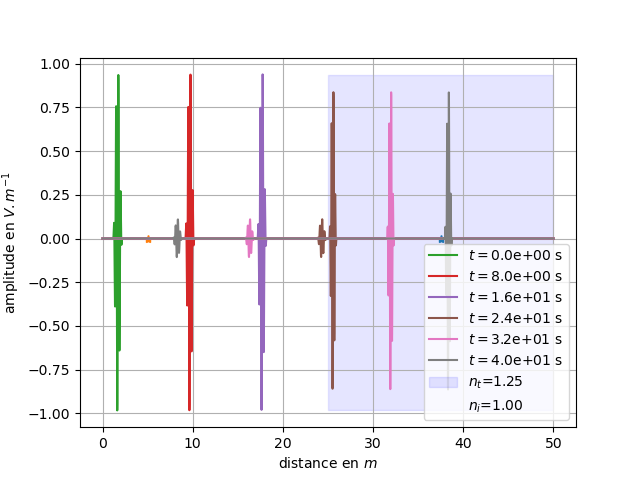

In [19]:
plt.figure()
plt.grid(True)
plt.fill_between([L/2, L], y1 = np.min(E_store[0]), y2 = np.max(E_store[0]), color = 'blue', alpha = .1, label=r"$n_t$="+str(format(max(c1,c2)/c2,"#.2f")))
plt.fill_between([0, L/2], y1 = np.min(E_store[0]), y2 = np.max(E_store[0]), color = 'white', alpha = .1, label=r"$n_i$="+str(format(max(c1,c2)/c1,"#.2f")))    # pour visualiser la zone plasma
plt.plot(x[3*Num_x//4], 0, '*')
plt.plot(x[Num_x//10], 0, '*')
for i in range(len(E_store)) :
    plt.plot(x,E_store[i], label=r"$t=$"+str(format(time_store[i], "#.1e"))+" s")
plt.xlabel(r"distance en $m$")
plt.ylabel(r"amplitude en $V.m^{-1}$")
plt.legend()
plt.show()

In [20]:
i_max1 = np.array([np.argmax(E_store[i][:len(E_store[i])//2]) for i in range(len(E_store))])
i_max2 = np.array([np.argmax(E_store[i][len(E_store[i])//2:]) for i in range(len(E_store))])
pos_max1 = np.array([np.abs(x[i_max1[i]]) for i in range(len(E_store))])
pos_max2 = np.array([np.abs(x[len(E_store[i])//2+i_max2[i]]) for i in range(len(E_store))])

val_i_max, val_t_max, val_r_max = [], [], []
pos_i_max, pos_t_max, pos_r_max = [], [], []
for i in range(len(i_max1)):
    if (x0 + c1*time_store[i] < L/2) :
        val_i_max.append(E_store[i][i_max1[i]])
        pos_i_max.append(x[i_max1[i]])
    else :
        val_r_max.append(E_store[i][i_max1[i]])
        pos_r_max.append(x[i_max1[i]])
        
for i in range(len(i_max2)):
    if x[len(E_store[i])//2+i_max2[i]] > 25 :
        val_t_max.append(E_store[i][len(E_store[i])//2+i_max2[i]])
        pos_t_max.append(x[len(E_store[i])//2+i_max2[i]])

c_i = np.array([(pos_i_max[i+1]-pos_i_max[i])/(time_store[i+1]-time_store[i]) for i in range(len(pos_i_max)-1)])
c_r = np.array([-(pos_r_max[i+1]-pos_r_max[i])/(time_store[i+1]-time_store[i]) for i in range(len(pos_r_max)-1)])
c_t = np.array([(pos_t_max[i+1]-pos_t_max[i])/(time_store[i+1]-time_store[i]) for i in range(len(pos_t_max)-1)])

t_amp_moy=np.mean(np.array(val_t_max)/np.array(val_i_max))
r_amp_moy=np.mean(np.array(val_r_max)/np.array(val_i_max))
t_amp_u=np.std(np.array(val_t_max)/np.array(val_i_max), ddof=1)
r_amp_u=np.std(np.array(val_r_max)/np.array(val_i_max), ddof=1)
print("Sur la base des mesures d'amplitude, t=",format(t_amp_moy,"#.3f"),"+/-",format(t_amp_u,"#.3f"))
print("Sur la base des mesures d'amplitude, r=",format(r_amp_moy,"#.3f"),"+/-",format(r_amp_u,"#.3f"))

t_c_moy = 2*np.mean(c_t/(c_i+c_t))
r_c_moy = np.mean((c_t-c_i)/(c_i+c_t))
t_c_u = 2*np.std(c_i/(c_i+c_t), ddof=1)
r_c_u = np.std((c_t-c_i)/(c_i+c_t), ddof=1)
print("Sur la base des mesures de vitesse, t=",format(t_c_moy,"#.3f"),"+/-",format(t_c_u,"#.3f"))
print("Sur la base des mesures de vitesse, r=",format(r_c_moy,"#.3f"),"+/-",format(r_c_u,"#.3f"))

Sur la base des mesures d'amplitude, t= 0.892 +/- 0.002
Sur la base des mesures d'amplitude, r= 0.117 +/- 0.001
Sur la base des mesures de vitesse, t= 0.889 +/- 0.000
Sur la base des mesures de vitesse, r= -0.111 +/- 0.000


Sur la base de cet exemple plutôt convaincant on peut multiplier les expériences numériques et en posant $x=\frac{n_1}{n_2}$, on peut évaluer un ensemble de valeurs comprises entre 1/1.5 et 1.5 et tracer les courbes 
$$r=\dfrac{x-1}{x+1}\qquad t=\dfrac{2}{x+1}$$

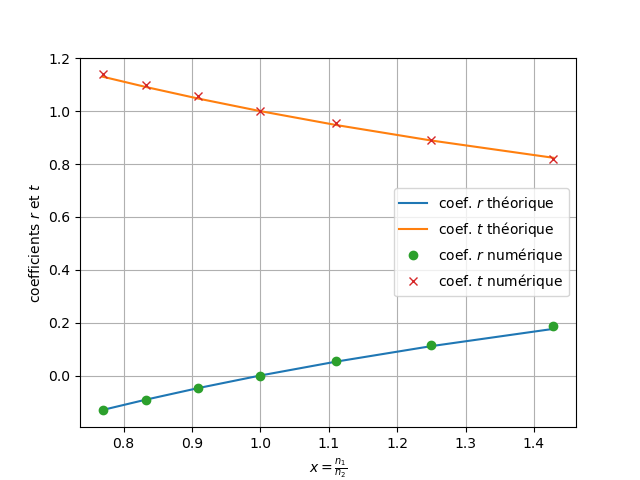

In [21]:
c1_num = np.array([1,1,1,1,1,1,1])
c2_num = np.array([.7, .8, .9, 1, 1.1, 1.2, 1.3])
x_num = c1_num / c2_num
r_num = [0.186,0.117,.055,0,-0.048,-.092,-0.132]
t_num = [0.820,0.892,0.955,1,1.057,1.099,1.139]

plt.figure()
plt.plot(x_num,(x_num-1)/(x_num+1), label=r"coef. $r$ théorique")
plt.plot(x_num,2/(x_num+1), label=r"coef. $t$ théorique")
plt.plot(x_num,r_num, 'o', label=r"coef. $r$ numérique")
plt.plot(x_num,t_num, 'x', label=r"coef. $t$ numérique")
plt.xlabel(r"$x=\frac{n_1}{n_2}$")
plt.ylabel(r"coefficients $r$ et $t$")
plt.legend()
plt.grid(True)
plt.show()

On peut également comparer les longueurs d'onde et les fréquences dans les deux milieux, à l'aide des signaux figés à $t=0$ et à $t=T$, et constater que la longueur d'onde est modifée lors du passage dans un milieu d'indice optique différent.

&nbsp;
Le spectre temporel est également grâce à une acquisition faite sur les capteurs $\text{cap}_i$ et $\text{cap}_t$ et montre que les fréquences sont, par contre, inchangées lors de cette même traversée de dioptre.

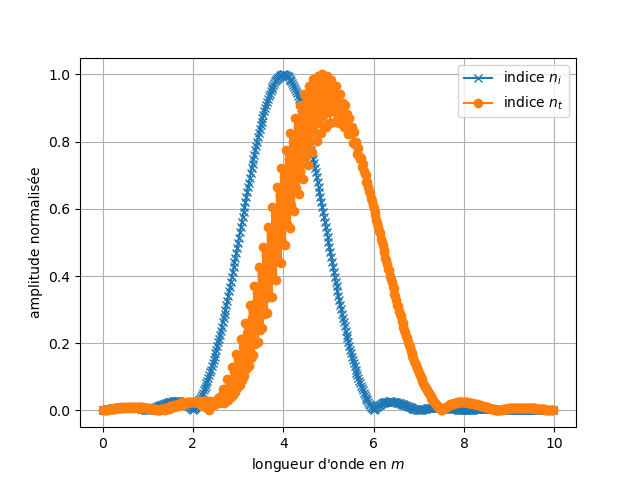

In [22]:
### Spectre du signal mesuré
## Spectre spatial
y_i = np.fft.rfft(E_store[0]/(len(E_store[0])//2+1))
sigma_i = np.array([i/np.max(x) for i in range(len(y_i))])
y_t = np.fft.rfft(E_store[5]/(len(E_store[5])//2+1))
sigma_t = np.array([i/np.max(x) for i in range(len(y_t))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(sigma_i[:int(Num_x//10)],np.abs(y_i)[:int(Num_x//10)]/np.max(np.abs(y_i)),'-x', label=r"indice $n_i$")
plt.plot(sigma_t[:int(Num_x//10)],np.abs(y_t)[:int(Num_x//10)]/np.max(np.abs(y_t)),'-o', label=r"indice $n_t$")
plt.legend()
plt.xlabel(r"longueur d'onde en $m$")
plt.ylabel('amplitude normalisée')
plt.grid(True)
plt.show()

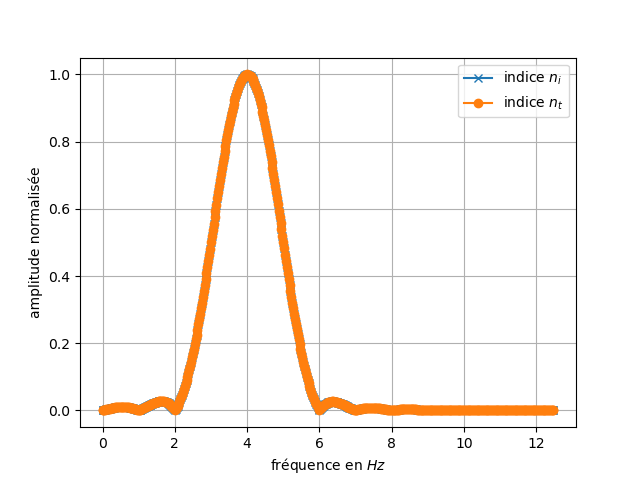

In [23]:
### Spectre du signal mesuré
## Spectre spatial
y_i = np.fft.rfft(np.array(capteur_i)/(len(capteur_i)//2+1))
freq_i = np.array([i/time for i in range(len(y_i))])
y_t = np.fft.rfft(np.array(capteur_t)/(len(capteur_t)//2+1))
freq_t = np.array([i/time for i in range(len(y_t))])


plt.figure()
# le spectre affiché est tronqué pour mieux les fréquences utiles
plt.plot(freq_i[:int(Num_x//10)],np.abs(y_i)[:int(Num_x//10)]/np.max(np.abs(y_i)),'-x', label=r"indice $n_i$")
plt.plot(freq_t[:int(Num_x//10)],np.abs(y_t)[:int(Num_x//10)]/np.max(np.abs(y_t)),'-o', label=r"indice $n_t$")
plt.legend()
plt.xlabel(r"fréquence en $Hz$")
plt.ylabel('amplitude normalisée')
plt.grid(True)
plt.show()

### Animation
On a également réalisé deux animations, illustrant la réflexion normale d'une onde sur un dioptre plan dans les cas où l'indice optique augmente avec le sens de propagation et dans le cas inverse.

&nbsp;
On constate visuellement que la longueur d'onde est effectivement modifiée, dans les deux cas. Dans le cas d'un passage d'un milieu moins réfringeant à un milieu plus réfringeant ($n_t>n_i$), le signal subit un déphasage de $\pi$ qui n'apparaît pas dans le cas contraire. Ce constat est conforme à la valeur négative possible de $r=\frac{n_i-n_t}{n_i+n_t}$.

In [24]:
from IPython.display import Video

Video("reflexion_inversion.mp4", width=640)

In [25]:
from IPython.display import Video

Video("reflexion_no_inversion.mp4", width=640)